In [2]:
import ee
import numpy as np
import pandas as pd

from earthshot import mon_stats
from earthshot import water_viz as vis
from earthshot import normalize as norm
from earthshot import water_common as common
from statistics import mean

import geemap.eefolium as geemap
import folium
from folium import plugins

import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [3]:
ee.Initialize()

In [15]:
#Join beaver dam tables

Data_Filter = ee.Filter.equals(leftField = 'system:index', rightField = 'system:index')
innerJoin = ee.Join.inner()

CA1_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CA1_Point_Data')
CA1_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CA1_creek_NDVI')
CA1_Data = innerJoin.apply(CA1_Point_Data, CA1_Tab_Data, Data_Filter)

CA2_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CA2_Point_Data')
CA2_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CA2_creek_NDVI')
CA2_Data = innerJoin.apply(CA2_Point_Data, CA2_Tab_Data, Data_Filter)

CO1_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CO1_Point_Data')
CO1_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CO1_creek_NDVI')
CO1_Data = innerJoin.apply(CO1_Point_Data, CO1_Tab_Data, Data_Filter)

CO2_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CO2_Point_Data')
CO2_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CO2_creek_NDVI')
CO2_Data = innerJoin.apply(CO2_Point_Data, CO2_Tab_Data, Data_Filter)

CO3_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CO3_Point_Data')
CO3_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CO3_creek_NDVI')
CO3_Data = innerJoin.apply(CO3_Point_Data, CO3_Tab_Data, Data_Filter)

CO4_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/Beaver_Dam_CO4_Point_Data')
CO4_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/CO4_tab_data')
CO4_Data = innerJoin.apply(CO4_Point_Data, CO4_Tab_Data, Data_Filter)

ID1_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/ID1_Point_Data')
ID1_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/ID1_creek_NDVI')
ID1_Data = innerJoin.apply(ID1_Point_Data, ID1_Tab_Data, Data_Filter)

ID2_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/ID2_Point_Data')
ID2_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/ID2_creek_NDVI')
ID2_Data = innerJoin.apply(ID2_Point_Data, ID2_Tab_Data, Data_Filter)

WY1_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/WY1_Point_Data')
WY1_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/WY1_creek_NDVI')
WY1_Data = innerJoin.apply(WY1_Point_Data, WY1_Tab_Data, Data_Filter)

WY2_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/WY2_Point_Data')
WY2_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/WY2_creek_NDVI')
WY2_Data = innerJoin.apply(WY2_Point_Data, WY2_Tab_Data, Data_Filter)

WY3_Point_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/WY3_Point_Data')
WY3_Tab_Data = ee.FeatureCollection('users/amgadellaboudy/beaver_dam/WY3_creek_NDVI')
WY3_Data = innerJoin.apply(WY3_Point_Data, WY3_Tab_Data, Data_Filter)

Wyoming_Beaver_Data = ee.FeatureCollection('users/amgadellaboudy/Wyoming_BeaverDam_Lengths').map(lambda x: x.set('Presence/absence (of beaver - present = 0, abse)', 0))


dam_data_points = (CA1_Data.merge(CA1_Data).merge(CA2_Data).merge(CO1_Data).merge(CO2_Data).merge(CO3_Data).merge(CO4_Data)
            .merge(ID1_Data).merge(ID2_Data).merge(WY1_Data).merge(WY2_Data).merge(WY3_Data))

def cleanJoin(feature):
    new_feature = ee.Feature(feature.get('primary')).copyProperties(feature.get('secondary'))
    return new_feature

dam_data_clean = dam_data_points.map(cleanJoin)
dam_data = dam_data_clean.merge(Wyoming_Beaver_Data)
print(CA1_Data.size().getInfo())

140


In [4]:
eco_regions = ee.FeatureCollection('users/amgadellaboudy/Eco_Regions')

spatialFilter = ee.Filter.intersects(leftField = '.geo', rightField = '.geo', maxError = 10)
eco_dam_data = innerJoin.apply(dam_data, eco_regions, spatialFilter)
eco_dam_data_clean = eco_dam_data.map(cleanJoin)
dam_feat = eco_dam_data_clean.remap(lookupIn = ['16', '21', '5'], lookupOut = [0, 1, 2], columnName = 'US_L3CODE')

In [5]:
#Import variables in (Slope, Porosity, Runoff, Soil Types, Annual Precipitation, water accumulation)
slope_img = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope')
#Scale = 90 m

smap_usda_clim = ee.ImageCollection('users/jamesmcc/smap_usda_climatology')
avail_porosity = (smap_usda_clim
                  .filter(ee.Filter.eq('band', 'avail_porosity_mm')))
avail_porosity_img = avail_porosity.sum()

runoff_clim = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select('surface_runoff')
runoff_clim_m = mon_stats.bands_avgs(['surface_runoff'], runoff_clim)
runoff_img = ee.ImageCollection(runoff_clim_m['avgs'].get('surface_runoff')).sum().multiply(720)
runoff_max = runoff_clim.max().multiply(720)

precip_clim = ee.Image("OpenLandMap/CLM/CLM_PRECIPITATION_SM2RAIN_M/v01")
precip_img = precip_clim.reduce('sum')
#https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_CLM_CLM_PRECIPITATION_SM2RAIN_M_v01#bands
#Scale = 1 km

soil_types = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")

top_soils = soil_types.expression('soil_0 + soil_10 + soil_30',
                             {'soil_0': soil_types.select('b0'),
                             'soil_10': soil_types.select('b10'),
                             'soil_30': soil_types.select('b30')})

water_img = ee.Image("MERIT/Hydro/v1_0_1").select('viswth')
#print(norm.img_range(water_img))
#https://developers.google.com/earth-engine/datasets/catalog/MERIT_Hydro_v1_0_1#bands
#Scale = 90 m

Landsat_8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_NDVI').filterDate('2020-01-01', '2020-12-31').select('NDVI').mean()
#2020 Landsat Data

In [6]:
training_img = slope_img.addBands(runoff_img).addBands(precip_img).addBands(top_soils).addBands(water_img).addBands(Landsat_8)
print(training_img.bandNames().getInfo())

['slope', 'surface_runoff', 'sum', 'b0', 'viswth', 'NDVI']


In [7]:
training = training_img.sampleRegions(dam_feat, scale = 30, geometries = True)
print(training.size().getInfo())

3920


In [8]:
target = 'NDVI'
bands = ['slope', 'surface_runoff', 'sum', 'b0', 'viswth', 'US_L3CODE', 'Presence/absence (of beaver - present = 0, abse)']

In [9]:
#Test/ validation split, fit classifier for training data

split = 0.7
training = training.randomColumn()

training_split = training.filter(ee.Filter.lt('random', split))
validation_split = training.filter(ee.Filter.gte('random', split))

classifier = ee.Classifier.smileGradientTreeBoost(500).setOutputMode('REGRESSION').train(features= training_split, classProperty= target, inputProperties = bands)

In [10]:
#Create predicted MAR intervention image and validation data

classified = training_split.classify(classifier)
validated = validation_split.classify(classifier)

In [11]:
#Training accuracy
from sklearn import metrics

selectors = ee.List(['NDVI', 'classification', 'Presence/absence (of beaver - present = 0, abse)'])
validated_list = ee.List(validated.reduceColumns(reducer = ee.Reducer.toList().repeat(selectors.size()), selectors = selectors).get('list'))
y_test = ee.List(validated_list.get(0)).getInfo()
predictions = ee.List(validated_list.get(1)).getInfo()
color = ee.List(validated_list.get(2)).getInfo()

RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print('RMSE:', RMSE)

RMSE: 0.036220695346279475


In [12]:
average_data = np.mean(y_test)
percentage = (RMSE/average_data)*100
print(percentage)

14.32642265601931


In [13]:
beaver_present = training.filter(ee.Filter.eq('Presence/absence (of beaver - present = 0, abse)', 0)).reduceColumns(reducer = ee.Reducer.mean(), selectors = ['NDVI'])
beaver_absent = training.filter(ee.Filter.eq('Presence/absence (of beaver - present = 0, abse)', 1)).reduceColumns(reducer = ee.Reducer.mean(), selectors = ['NDVI'])

In [14]:
print(beaver_present.getInfo())

{'mean': 0.2575702825635493}


In [15]:
print(beaver_absent.getInfo())

{'mean': 0.23722484944944167}


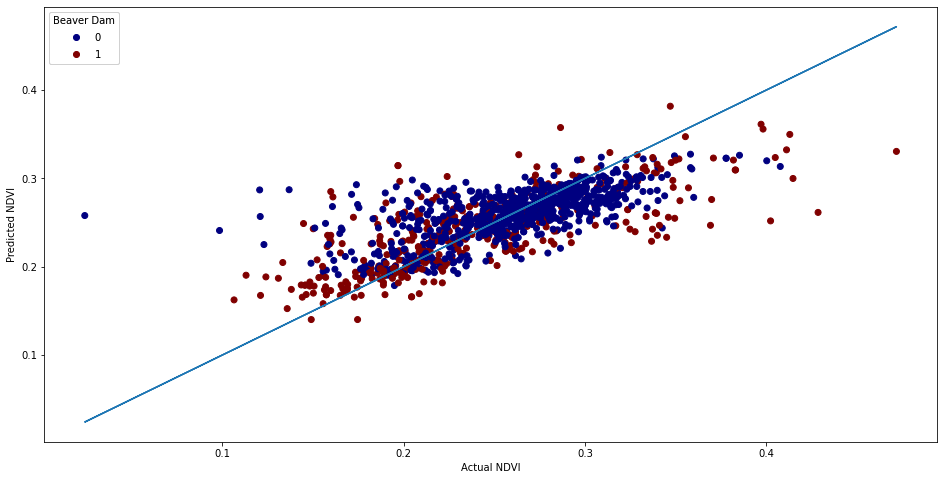

In [16]:


fig, ax = plt.subplots()

scatter = ax.scatter(y_test, predictions, c = color, cmap = 'jet')
plot = ax.plot(y_test, y_test)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Beaver Dam")
ax.add_artist(legend1)

plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()


In [16]:
Wyoming_Points = Wyoming_Beaver_Data.map(lambda y: y.centroid(maxError =1))

In [17]:
print(Wyoming_Points.getInfo())

{'type': 'FeatureCollection', 'columns': {'Name': 'String', 'Presence/absence (of beaver - present = 0, abse)': 'Integer', 'altitudeMo': 'String', 'begin': 'String', 'descriptio': 'String', 'end': 'String', 'extrude': 'Long', 'icon': 'String', 'layer': 'String', 'path': 'String', 'system:index': 'String', 'tessellate': 'Long', 'timestamp': 'String', 'visibility': 'Long'}, 'version': 1628184116324364, 'id': 'users/amgadellaboudy/Wyoming_BeaverDam_Lengths', 'properties': {'system:asset_size': 243595}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-105.37026326738386, 41.25490152844549]}, 'id': '00000000000000000000', 'properties': {'Name': 'Dam351Length', 'Presence/absence (of beaver - present = 0, abse)': 0, 'altitudeMo': '', 'begin': '', 'descriptio': '', 'end': '', 'extrude': 0, 'icon': '', 'layer': 'Dam351Length Dam351Length.kmz', 'path': 'D:/EarthShot/Beaver_Dam_data/Beaver_Dam_and_Pond_kmz_Files/Dam351Length.kmz|layername=Dam351Length.kmz', 'tessell

100%|██████████| 676/676 [07:43<00:00,  1.46it/s]


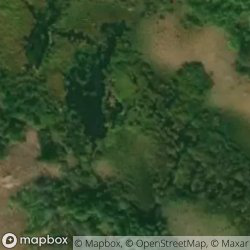

In [129]:
image_collection[500]

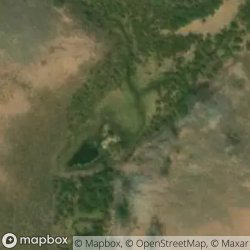

In [92]:
i

In [6]:
print(Contains_WY_beaver_dams.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-105.44064820305194, 41.192965942925824], [-105.43944419865024, 41.19296595766235], [-105.43944419865024, 41.19416542221515], [-105.44064820305194, 41.19416547800082], [-105.44064820305194, 41.192965942925824]]]}, 'id': '0000000000000000017b', 'properties': {'angle': 225.000000021984, 'area': 1e-06, 'cat': 180, 'distance': 0, 'fid': 558, 'height': 0.0012, 'network': 61, 'perimeter': 0.0048, 'stream_typ': 'start', 'type_code': 0, 'width': 0.0012}}


In [84]:


response = requests.get(
        url='https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/[-105.3727,41.2538,-105.3711,41.255]/250x250?access_token=pk.eyJ1IjoicHVpd2FoIiwiYSI6ImNrbHM1djlhdDBiM28yb28xbmExM2d0M20ifQ.uFj_qHx0c3OTNu5o-Njf4g',
           )

In [85]:
from PIL import Image
from io import BytesIO

i = Image.open(BytesIO(response.content))

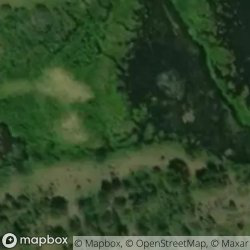

In [86]:
i

In [24]:
curl -g "https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/[-105.3739,41.2525,-105.368,41.2569]/1280x1280?access_token=pk.eyJ1IjoicHVpd2FoIiwiYSI6ImNrbHM1djlhdDBiM28yb28xbmExM2d0M20ifQ.uFj_qHx0c3OTNu5o-Njf4g" --output dam_wy.png

SyntaxError: invalid syntax (<ipython-input-24-9915aeb43d00>, line 1)